In this tutorial we learn how to train the Variational Auto Encoder (VAE) model to reconstruct and generate Dual phase steel microstructures.

<span style="color: blue;">**Data Preprocessing**</span>


After generating the microstructure data set, we pre-process the data before providing it to the ML model. The microstructure is represented as a 2D image of 128 × 128 pixels where each pixel contains the information about phase and orientation of the crystal lattice. For each microstructure, we have 128 × 128 × 6 numerical values for the orientation data. The data is normalized to 
 before feeding it to the VAE model. This helps to design the ML model in a way such that it always outputs the numerical values in the range [0, 1]. In addition, a scalar is needed to encode the phase information. We represent the martensite with 
 and the ferrite phase with 
. The orientation data is concatenated with the phase data and the microstructure is represented as a 2D image with 7 channels

<span style="color: blue;">**Loss Function**</span>

The loss function we use to train the VAE model is a combination of reconstruction loss and KL divergence loss derived from variational inference technique kingma2014:
\begin{equation}
\label{eq:vae loss}
\mathcal{L}(\mathbf{x},\tilde{\mathbf{x}}) = \underbrace{\mathbb{E}_{\mathbf{z}\sim q_{\phi( \mathbf{z|x})}}[\log p_{\theta}(\mathbf{x|z})]}_\text{Reconstruction loss} - \underbrace{D_\mathrm{KL}[q_{\phi}(\mathbf{z|x})\parallel p_{\theta}(\mathbf{z})]}_\text{KL divergence loss}
\end{equation}

The reconstruction loss measures the reconstruction error between the original input $\mathbf{x}$ and reconstructed output $\mathbf{\tilde{x}}$.
The KL divergence loss measures the information loss  between the true distribution of the latent variables $p_\theta(\mathbf{z})$ and the probability distribution of latent encodings learned by the encoder $q_\phi(\mathbf{z|x})$.
The encoded distribution of latent vector $\mathbf{z}$ is assumed to be a normal distribution $q_\phi(\mathbf{z|x}) = \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma})$ and the true distribution of $\mathbf{z}$ to be a standard normal distribution $p_\theta(\mathbf{z}) = \mathcal{N}(0, \mathbf{I})$.
This assumption helps to write the KL divergence loss $\mathcal{L}_{\mathrm{KL}}$ in closed form, in terms of the mean and the covariance matrices of both distributions:
\begin{equation} \label{eq:KL loss}
\mathcal{L}_{\mathrm{KL}}  =\sum_{i=1}^{n}\boldsymbol{\sigma}^{2}_{i} + \boldsymbol{\mu}^{2}_{i} - \log (\boldsymbol{\sigma}_{i})-1
\end{equation}

To train the VAE neural networks, kingma2014 introduced a reparameterization in which instead of the stochastic latent vector $\mathbf{z} \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma})$, $\mathbf{z} = \boldsymbol{\mu} + \boldsymbol{\sigma}\odot \epsilon$ with $\epsilon \sim \mathcal{N}(0, 1)$ is used.
This reparameterization helps to take the derivative of the loss function w.r.t $\boldsymbol{\mu}, \boldsymbol{\sigma}, \mathbf{z}$ and update the parameters of the encoder $\phi$ and decoder $\theta$ using the backpropagation algorithm .

Typically, the mean squared error $\mathcal{L}_{\mathrm{MSE}} = \left \| \mathbf{x} - \mathbf{\tilde{x}}\right \|^{2} $ for the full feature vector is used to measure the similarity between the original and reconstructed data \citep{kingma2014} .
However, VAE models trained with this pixel-level similarity loss are prone to generate blurry images 
In this work, we use an additional deep perceptual loss to improve the reconstruction quality.
Deep perceptual loss measures the visual perceptual difference between the features identified by different layers of a pre-trained CNN from the original and reconstructed microstructures.
The perceptual loss between the features $\Phi(\mathbf{x})^{l}$  and $\Phi(\tilde{\mathbf{x}})^{l}$  identified by the $l^{th}$ layer of the pre-trained CNN model $\Phi$ in original and reconstructed images $\mathbf{x}$ and $\mathbf{\tilde{x}}$ is given by


\begin{equation} \label{eq:perceptual Loss}
\mathcal{L}_{\mathrm{perceptual}}^{l} = \frac{1}{2C^{l}W^{l}H^{l}}\sum_{c=1}^{C^{l}}\sum_{w=1}^{W^{l}}\sum_{h=1}^{H^{l}}(\Phi(\mathbf{x})^{l}_{c,w,h} - \Phi(\mathbf{\tilde{x}})^{l}_{c,w,h})^{2},
\end{equation}
\noindent where $W^{l}$,  $H^{l}$ are width and the height of each feature map and $C^{l}$ represents the number of filters in the $l^{th}$ layer.
We use the weighted sum of three layers  *block1\_conv1*, *block2\_conv1*, *block2\_pool* of the pre-trained VGG19 model to calculate the perceptual loss separately for the two basis vectors $\mathbf{b}_{1}, \mathbf{b}_{2}$.


**Orientation loss**
In addition to the mean square error, we use the disorientation loss in the reconstruction loss.
Disorientation loss measures the discrepancy between the two specific orientations that belong to the same crystal family. 
Considering the cubic crystal symmetry, we calculate the disorientation value as the minimum rotation angle among the list of all total 24 symmetrical misorientations.
This disorientation value is calculated for each pixel in the original microstructure and the corresponding pixel in the reconstructed microstructure. 
The total reconstruction loss $\mathcal{L}_{\mathrm{rec}}$ is a weighted sum of mean squared error $\mathcal{L}_{\mathrm{MSE}}$, perceptual loss $\mathcal{L}_{\mathrm{perceptual}}$, disorientation loss $\mathcal{L}_{\mathrm{disorientation}}$ and additional constraints 
$\mathcal{L}_{\mathrm{norm}}$ and $\mathcal{L}_{\mathrm{orthogonal}}$ to ensure that the two basis vectors are of unit length and orthogonal:
\begin{equation}\label{eq:Total reconst loss}
\mathcal{L}_{\mathrm{rec}} = \alpha_{1}\mathcal{L}_{\mathrm{MSE}} + \alpha_{2}\mathcal{L}_{\mathrm{perceptual}} + 
\alpha_{3}\mathcal{L}_{\mathrm{disorientation}}+ \alpha_{4}\mathcal{L}_{\mathrm{norm}} + \alpha_{5}\mathcal{L}_{\mathrm{orthogonal}},
\end{equation}
which is part of the total loss function $\mathcal{L}$ that is minimized during training of the VAE model:
\begin{equation}\label{eq:Total loss}
\mathcal{L} = \alpha\mathcal{L}_{\mathrm{rec}} + \beta\mathcal{L}_{\mathrm{KL}}
\end{equation}
Minimizing the reconstruction loss $\mathcal{L}_{\mathrm{rec}}$ ensures that the reconstructed microstructure images are close to the input images and minimizing  the KL divergence loss $\mathcal{L}_{\mathrm{KL}}$ ensures that the latent features learned by the encoder model follow a standard normal distribution.
We use $\alpha_{1} = 1.0$, $\alpha_{2} = 2.0$, $\alpha_{3} = 0.5$, $\alpha_{4} = 0.03$,  $\alpha_{5} = 0.2$, $\alpha =1.0$, $\beta = 3.0$, to ensure that the contribution of all losses are in a similar range.



*Kingma D.P., Welling M. Auto-encoding variational Bayes Bengio Y., LeCun Y. (Eds.), 2nd International Conference on Learning Representations (ICLR2014), Conference Track Proceedings (2014), 10.48550/arXiv.1312.6114*

 <span style="color: blue;">**VAE Architecture**</span>

The VAE Architecture of the encoder and the decoder models used in the current study is shown in the following image. The encoder is a deep convolutional neural network (CNN) that takes a 2D image of size $128\times128$ with $7$ channels as input and converts it into two vectors, $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$, each of size $d_{l}$.
The first channel consists of information about the phase distribution of martensite islands (black pixels) inside the ferrite matrix (white pixels).
The remaining six channels contain crystal orientation information represented using two orthogonal basis vectors and shown as gray-scale images (re-scaled to range \text{[0, 1]}).
The microstructure images are represented as low-dimensional vectors in the probabilistic latent space, which is a multivariate normal distribution parameterized by mean $\boldsymbol{\mu}$ and standard deviation $\boldsymbol{\sigma}$.
The decoder is a deep CNN that converts the sample taken from the latent space ($\boldsymbol{z}$), into an image of size $128\times128\times7$, using a combination of 2D convolution and 2D transposed convolution layers.
In this tutorial we train VAE with latent space dimension $d_{l}$ to  256.


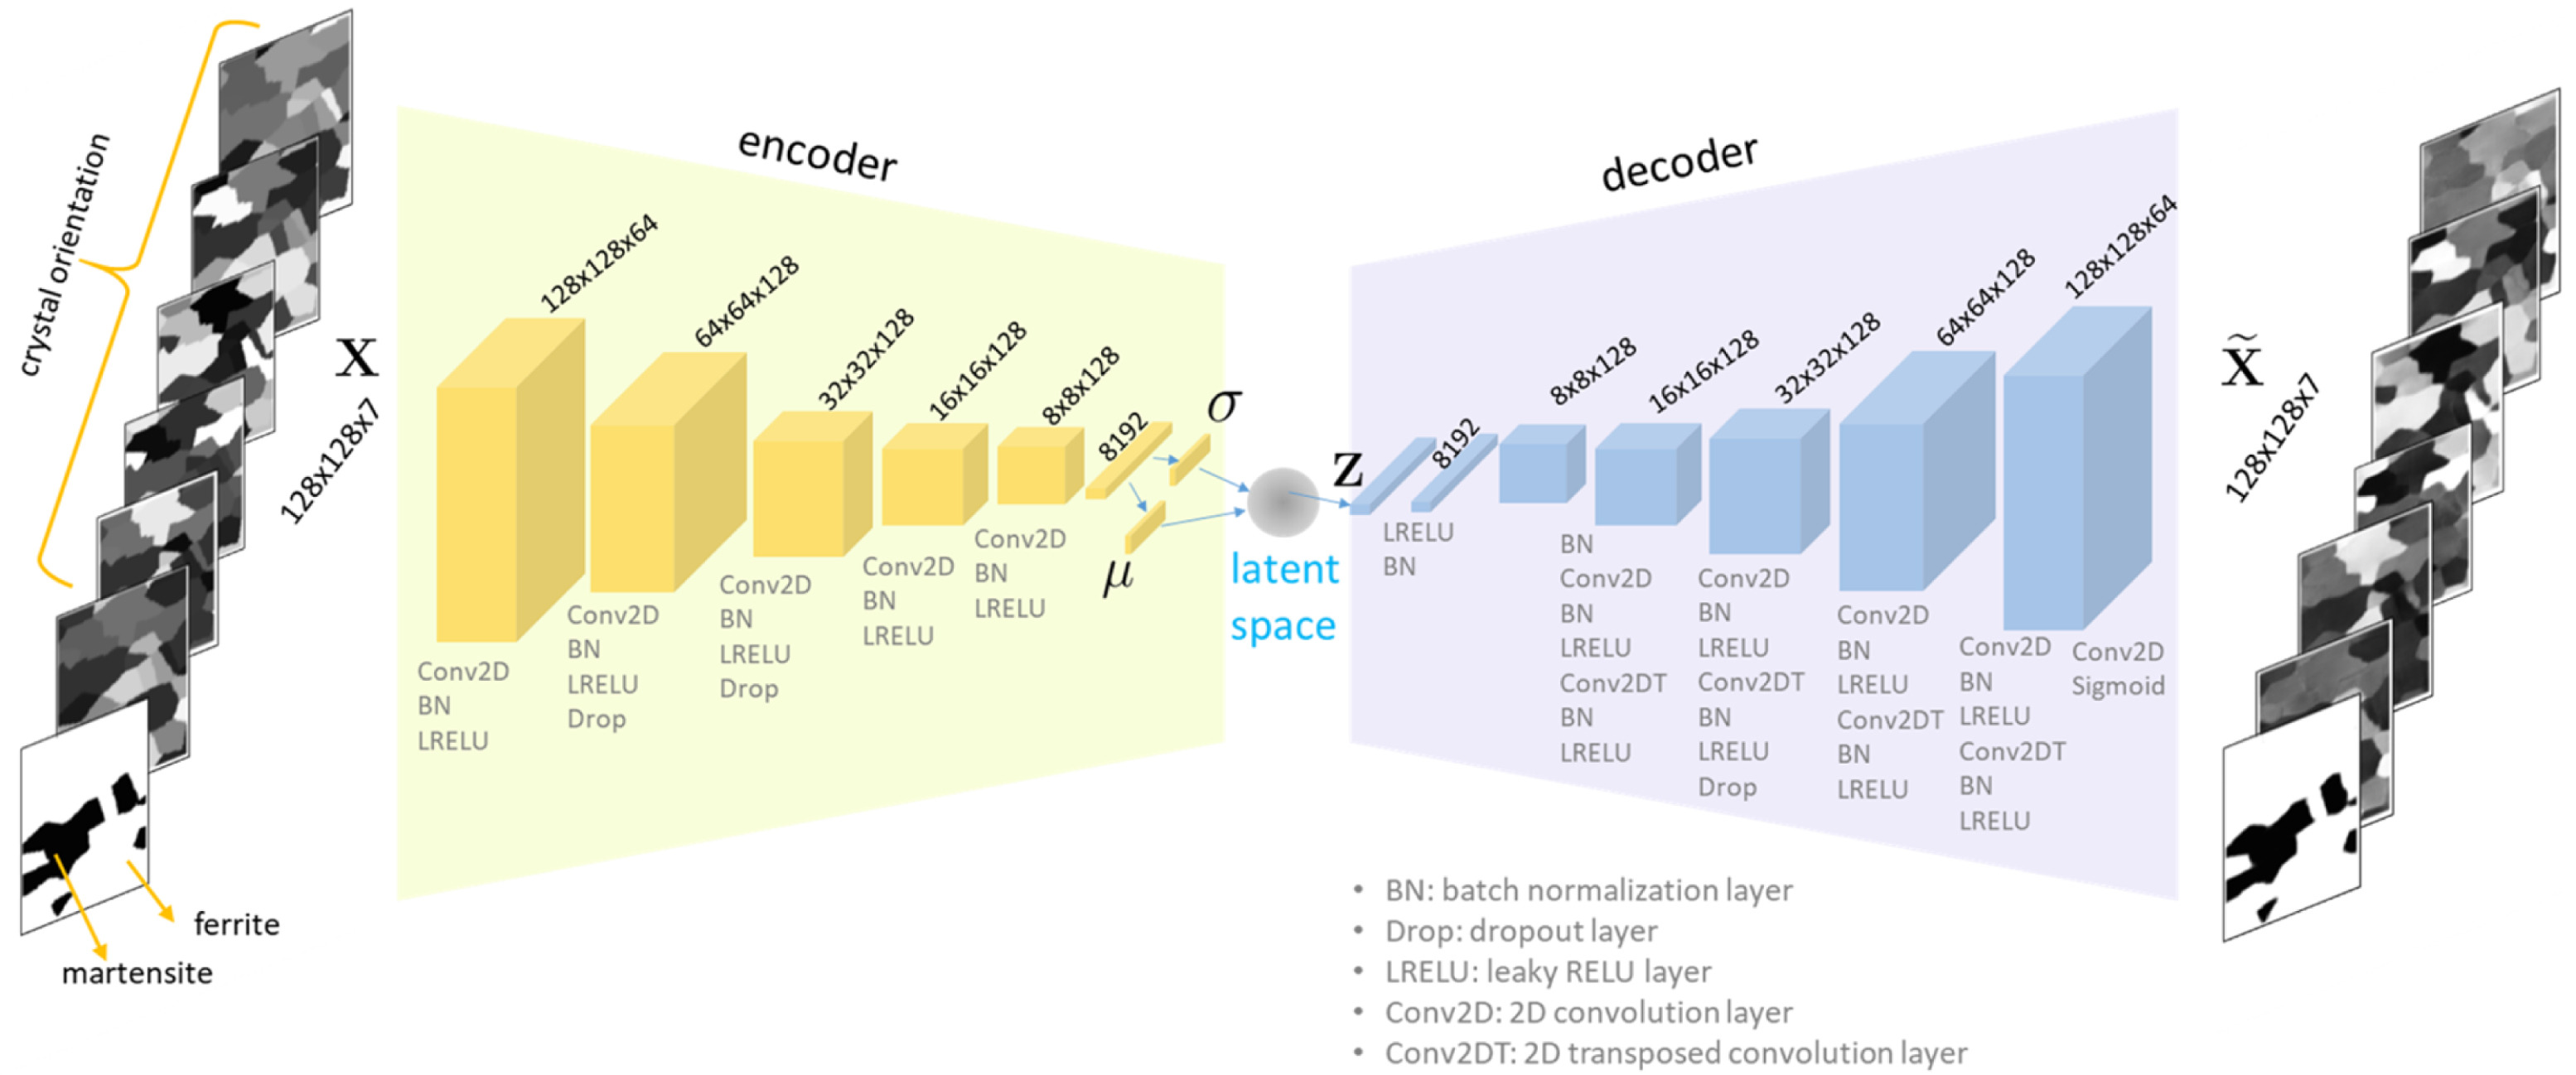

#### Setup and import libraries

In [ ]:
#@title import libraries
import tensorflow as tf

In [ ]:
# check the availablity of all GPU machiens
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

In [ ]:
# select first GPU machine 
tf.config.set_visible_devices(gpus[0], 'GPU')
logical_gpus = tf.config.list_logical_devices('GPU')

# verify the setup
logical_gpus = tf.config.list_logical_devices('GPU')
print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

In [ ]:
import numpy as np
import h5py
import damask
from tensorflow import keras
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import layers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
%pylab inline

In [ ]:
print("damask: ",damask.__version__)
print("keras: ",keras.__version__)
print("Tensorflow: ",tf.__version__)

The following version were used
```
damask:  3.0.0-alpha5-495-g814d89532
keras:  2.11.0
Tensorflow:  2.11.0
```

#### Create a sampling layer


In [ ]:
class Sampling(layers.Layer):
    """
    Sampling layer for a Variational Autoencoder (VAE).

    This layer uses the reparameterization trick to sample from a distribution defined by
    the mean and log variance vectors. It generates a random sample z from the latent 
    space, which is used to encode a digit.

    Methods:
        call(inputs): Generates a sample z from the latent space.
    """
    
    def call(self, inputs):
        """
        Generate a sample z from the latent space using (z_mean, z_log_var).
        
        Args:
            inputs: A tuple containing z_mean and z_log_var.
        
        Returns:
            z: A sampled latent vector.
        """
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

#### Build the encoder and decoder 


In [ ]:
latent_dim = 256
def get_encoder():
    """
    Build the encoder model for a Variational Autoencoder (VAE).

    This function constructs the encoder part of a VAE, which encodes the input data into 
    a latent space. The encoder consists of several convolutional layers followed by 
    batch normalization, LeakyReLU activation, and dropout layers. The output includes 
    the mean and log variance of the latent variables, and a sampled latent vector using 
    the reparameterization trick.

    Returns:
        encoder: A Keras Model instance representing the encoder.
    """
    
    # Define the input layer
    encoder_inputs = keras.Input(shape=(128, 128, 7))
    
    # First convolutional block
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", strides=(1, 1))(encoder_inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    
    # Second convolutional block
    x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(rate=0.25)(x)
    
    # Third convolutional block
    x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(rate=0.25)(x)
    
    # Fourth convolutional block
    x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    
    # Fifth convolutional block
    x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    
    # Flatten the output of the convolutional layers
    x = keras.layers.Flatten()(x)
    
    # Define the mean and log variance for the latent variables
    z_mean = keras.layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = keras.layers.Dense(latent_dim, name="z_log_var")(x)
    
    # Use the Sampling layer to generate a latent vector
    z = Sampling()([z_mean, z_log_var])
    
    # Create the encoder model
    encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    
    return encoder

In [ ]:
def get_decoder():
    """
    Build the decoder model for a Variational Autoencoder (VAE).

    This function constructs the decoder part of a VAE, which decodes the latent space 
    representation back into the original data space. The decoder consists of several 
    convolutional and transposed convolutional layers followed by batch normalization 
    and LeakyReLU activation.

    Returns:
        decoder: A Keras Model instance representing the decoder.
    """
    
    # Define the input layer for the latent vector
    latent_inputs = keras.Input(shape=(latent_dim,))
    
    # First dense layer to reshape latent vector to a 3D volume
    x = keras.layers.Dense(8 * 8 * 128)(latent_inputs)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Reshape((8, 8, 128))(x)
    x = keras.layers.BatchNormalization()(x)
    
    # First convolutional block
    x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=(1, 1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    
    # First transposed convolutional block
    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=(1, 1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    
    # Second transposed convolutional block
    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dropout(rate=0.25)(x)
    x = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", strides=(1, 1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    
    # Third transposed convolutional block
    x = keras.layers.Conv2DTranspose(filters=128, kernel_size=(3, 3), padding="same", strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(5, 5), padding="same", strides=(1, 1))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    
    # Fourth transposed convolutional block
    x = keras.layers.Conv2DTranspose(filters=64, kernel_size=(5, 5), padding="same", strides=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", strides=(1, 1))(x)
    x = keras.layers.LeakyReLU()(x)
    
    # Output layer to generate the final reconstructed image
    decoder_outputs = keras.layers.Conv2D(7, 3, strides=(1, 1), padding="same", activation="sigmoid", name="image")(x)
    
    # Create the decoder model
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
    
    return decoder

In [ ]:
# create Encoder and decoder model 
encoder = get_encoder()
decoder = get_decoder()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

#### Define the VAE as a Model with a custom train_step

In [ ]:
def MSE_loss(true, predicted):
    """
    Compute the Mean Squared Error (MSE) loss for a batch of images.

    This function calculates the MSE loss between the true and predicted images. It flattens
    the images in the batch, computes the MSE for each image, and then scales the mean MSE 
    by the image dimensions to return a scalar value.

    Args:
        true: The ground truth images.
        predicted: The predicted images.

    Returns:
        loss: The MSE loss as a scalar value.
    """
    
    # Compute MSE loss for each image in the batch
    mse_loss = losses.mean_squared_error(
        K.batch_flatten(true), 
        K.batch_flatten(predicted)
    )
    
    # Scale and return the mean MSE loss for the batch
    return 128 * 128 * 7 * K.mean(mse_loss)

In [ ]:
# Load the pre-trained VGG19 model without the top classification layer
# This model will be used to calculate the perceptual loss
VGG19_model = VGG19(include_top=False, input_shape=(128, 128, 3))

# Names and weights of perceptual model layers selected for calculating the perceptual loss
# The selected layers and their corresponding weights determine their contribution to the perceptual loss
selected_pm_layers = ['block1_conv1', 'block2_conv1', 'block2_pool']
selected_pm_layer_weights = [1.0, 0.5, 0.3]

# Get the outputs of the selected layers from the VGG19 model
outputs = [VGG19_model.get_layer(layer_name).output for layer_name in selected_pm_layers]

# Create a new model with the VGG19 input and the selected layer outputs
# This new model will provide the necessary outputs for the perceptual loss calculation
VGG19_updated_model = keras.Model(VGG19_model.input, outputs)

In [ ]:
VGG19_model.summary()

In [ ]:
VGG19_updated_model.summary()

In [ ]:
def perceptual_loss(true, predicted):
    """
    Compute the perceptual loss between the true and predicted images.

    This function calculates the perceptual loss by comparing the activations of a 
    pre-trained perceptual model (VGG19) for the true and predicted images. The loss 
    is computed as a weighted sum of the squared differences of the activations from 
    selected layers of the perceptual model.

    Args:
        true: The ground truth images.
        predicted: The predicted images.

    Returns:
        loss: The perceptual loss as a scalar value.
    """
    
    # Get the activations of the selected layers for the true and predicted images
    h1_list = VGG19_updated_model(true)
    h2_list = VGG19_updated_model(predicted)
    
    # Initialize the reconstruction loss
    rc_loss = 0.0
    
    # Calculate the weighted sum of the squared differences of the activations
    for h1, h2, weight in zip(h1_list, h2_list, selected_pm_layer_weights):
        h1 = K.batch_flatten(h1)
        h2 = K.batch_flatten(h2)
        rc_loss = rc_loss + weight * K.sum(K.square(h1 - h2), axis=-1)
    
    # Return the mean loss for all images in the batch, scaled by 1e-3
    return K.mean(rc_loss) / 1e3


In [ ]:
def orientation_constraint_loss(true, predicted):
    """
    Compute the orientation constraint loss between the true and predicted basis vectors.

    This function calculates the orientation constraint loss to ensure the basis vectors 
    have unit norm and are orthogonal. The loss includes three components: the norm of 
    the first basis vector, the norm of the second basis vector, and the dot product 
    between the two basis vectors.

    Args:
        true: The ground truth basis vectors.
        predicted: The predicted basis vectors.

    Returns:
        b1_norm_loss: The loss for the norm of the first basis vector.
        b2_norm_loss: The loss for the norm of the second basis vector.
        b1b2_dotProduct_loss: The loss for the dot product between the two basis vectors.
    """
    
    # Process the true basis vectors
    b1_true = tf.reshape(true[..., 1:4], (-1, 3))  # Reshape to batch_size*128*128 x 3
    b2_true = tf.reshape(true[..., 4:7], (-1, 3))  # Reshape to batch_size*128*128 x 3
    # Convert range to [-1, 1]
    b1_true = b1_true * 2.0 - 1.0
    b2_true = b2_true * 2.0 - 1.0

    # Compute norms and dot product for true basis vectors
    b1_true_norm = tf.norm(b1_true, axis=1)  # Norm of b1_true
    b2_true_norm = tf.norm(b2_true, axis=1)  # Norm of b2_true
    b1b2_dotProduct_true = K.batch_dot(b1_true, b2_true)[:, 0]  # Dot product of b1_true and b2_true

    # Process the predicted basis vectors
    b1_pred = tf.reshape(predicted[..., 1:4], (-1, 3))  # Reshape to batch_size*128*128 x 3
    b2_pred = tf.reshape(predicted[..., 4:7], (-1, 3))  # Reshape to batch_size*128*128 x 3
    # Convert range to [-1, 1]
    b1_pred = b1_pred * 2.0 - 1.0
    b2_pred = b2_pred * 2.0 - 1.0

    # Compute norms and dot product for predicted basis vectors
    b1_pred_norm = tf.norm(b1_pred, axis=1)  # Norm of b1_pred
    b2_pred_norm = tf.norm(b2_pred, axis=1)  # Norm of b2_pred
    b1b2_dotProduct_predicted = K.batch_dot(b1_pred, b2_pred)[:, 0]  # Dot product of b1_pred and b2_pred
    
    # Calculate the orientation constraint losses
    b1_norm_loss = 64 * 128 * 128 * losses.mean_squared_error(b1_true_norm, b1_pred_norm)  # Loss for b1 norm
    b2_norm_loss = 64 * 128 * 128 * losses.mean_squared_error(b2_true_norm, b2_pred_norm)  # Loss for b2 norm
    b1b2_dotProduct_loss = 64 * 128 * 128 * losses.mean_squared_error(b1b2_dotProduct_true, 
                                                                       b1b2_dotProduct_predicted
                                                                      )                   # Loss for b1.b2 orthogonality

    return b1_norm_loss, b2_norm_loss, b1b2_dotProduct_loss  # Return the scalar values of the losses

In [ ]:
# Define the batch size
batch_size = 64

# Define the symmetry operations for the cubic crystal family
family = 'cubic'
R_sym = damask.Orientation(family=family).symmetry_operations.as_matrix()
R_sym = tf.constant(R_sym, dtype='float32')
N_sym = R_sym.shape[0]

def Symmetry_loss(true, predicted):
    """
    Compute the symmetry loss between the true and predicted orientations.

    This function calculates the symmetry loss to ensure the predicted orientations 
    adhere to the symmetry constraints of the crystal family. It avoids 'nan' values 
    during the acos computation by clipping the input to the valid range.

    Args:
        true: The ground truth basis vectors.
        predicted: The predicted basis vectors.

    Returns:
        loss: The symmetry loss as a scalar value.
        
    Code contributer: Martin Diehl and Navyanth Kusampudi
    """
    
    # Small constant to avoid division by zero and nan values in acos
    eps = 1e-9
    
    # Process the true basis vectors
    b_1 = tf.reshape(true[..., 1:4], (-1, 3))
    b_2 = tf.reshape(true[..., 4:7], (-1, 3))
    
    # Process the predicted basis vectors
    b_1_tilde = tf.reshape(predicted[..., 1:4], (-1, 3))
    b_2_tilde = tf.reshape(predicted[..., 4:7], (-1, 3))
    
    # Convert the range to [-1, 1]
    b_1 = b_1 * 2.0 - 1.0
    b_2 = b_2 * 2.0 - 1.0
    b_1_tilde = b_1_tilde * 2.0 - 1.0
    b_2_tilde = b_2_tilde * 2.0 - 1.0
    
    # Number of elements in the batch
    N = batch_size * 128 * 128
    
    # Normalize the true basis vectors
    b_1 /= tf.linalg.norm(b_1, axis=1, keepdims=True) + eps
    b_2 -= tf.expand_dims(tf.einsum('ai,ai->a', b_2, b_1), -1) * b_1
    b_2 /= tf.linalg.norm(b_2, axis=1, keepdims=True)
    R = tf.stack((b_1, b_2, tf.linalg.cross(b_1, b_2)), -2)  # Shape: batch_size*128*128 x 3 x 3

    # Normalize the predicted basis vectors
    b_1_tilde /= tf.linalg.norm(b_1_tilde, axis=1, keepdims=True) + eps
    b_2_tilde -= tf.expand_dims(tf.einsum('ai,ai->a', b_2_tilde, b_1_tilde), -1) * b_1_tilde
    b_2_tilde /= tf.linalg.norm(b_2_tilde, axis=1, keepdims=True) + eps
    R_tilde = tf.stack((b_1_tilde, b_2_tilde, tf.linalg.cross(b_1_tilde, b_2_tilde)), -2)  # Shape: batch_size*128*128 x 3 x 3
    
    # Broadcast symmetry operations
    R_sym_ = tf.broadcast_to(tf.expand_dims(R_sym, 1), (N_sym, N, 3, 3))  # Shape: N_sym x batch_size*128*128 x 3 x 3
    R_ = tf.broadcast_to(R, (N_sym, N, 3, 3))  # Shape: N_sym x batch_size*128*128 x 3 x 3
    R_tilde_ = tf.broadcast_to(R_tilde, (N_sym, N, 3, 3))  # Shape: N_sym x batch_size*128*128 x 3 x 3
    
    # Compute the misorientation
    Delta = tf.einsum('abij,abjk,ablk->abil', R_sym_, R_, R_tilde_)  # Shape: N_sym x batch_size*128*128 x 3 x 3
    angle = tf.reduce_min(tf.math.acos(tf.clip_by_value((tf.linalg.trace(Delta) - 1) * 0.5, -1 + 1e-6, 1 - 1e-6)), axis=0) 
                                                                    # Shape: batch_size*128*128

    # Return the mean angle as the symmetry loss
    return 128 * 128 * tf.reduce_mean(angle)  # Scalar loss value

In [ ]:
class VAE(keras.Model):
    """
    Variational Autoencoder (VAE) class.
    
    This class defines a VAE with custom loss functions, including MSE loss, perceptual loss, 
    orientation constraint loss, and symmetry loss. The VAE consists of an encoder and a decoder 
    and tracks various loss components during training.
    
    Args:
        encoder: The encoder model.
        decoder: The decoder model.
        **kwargs: Additional keyword arguments for the keras.Model class.
    """
    
    def __init__(self, encoder, decoder, **kwargs):
        
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        self.mse_loss_tracker = keras.metrics.Mean(name="mse_loss")
        self.symmetry_loss_tracker = keras.metrics.Mean(name="symmetry_loss")
        self.percep_loss_1_tracker = keras.metrics.Mean(name="percep_loss_1")
        self.percep_loss_2_tracker = keras.metrics.Mean(name="percep_loss_2")
        self.b1_norm_loss_tracker = keras.metrics.Mean(name="b1_norm_loss")
        self.b2_norm_loss_tracker = keras.metrics.Mean(name="b2_norm_loss")
        self.b1b2_dotProduct_loss_tracker = keras.metrics.Mean(name="b1b2_dotProduct_loss")
    
    @property
    def metrics(self):
        """
        Returns a list of tracked metrics for monitoring during training.
        """
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.mse_loss_tracker,
            self.symmetry_loss_tracker,
            self.percep_loss_1_tracker,
            self.percep_loss_2_tracker,
            self.b1_norm_loss_tracker,
            self.b2_norm_loss_tracker,
            self.b1b2_dotProduct_loss_tracker
        ]

    def train_step(self, data):
        """
        Training step for the VAE.
        
        Args:
            data: Input data for the VAE.
        
        Returns:
            A dictionary of the tracked losses.
        """
        with tf.GradientTape() as tape:
            # Encode input data to get latent variables
            z_mean, z_log_var, z = self.encoder(data)
            
            # Decode latent variables to reconstruct images
            reconstruction = self.decoder(z)
            
            # Compute various loss components
            mse_loss = MSE_loss(data, reconstruction)
            percep_loss_1 = perceptual_loss(data[..., 1:4], reconstruction[..., 1:4])
            percep_loss_2 = perceptual_loss(data[..., 4:7], reconstruction[..., 4:7])
            b1_norm_loss, b2_norm_loss, b1b2_dotProduct_loss = orientation_constraint_loss(data, reconstruction)
            symmetry_loss = Symmetry_loss(data, reconstruction)
            
            # Aggregate reconstruction loss
            reconstruction_loss = (
                mse_loss +
                0.5 * symmetry_loss +
                2.0 * percep_loss_1 +
                2.0 * percep_loss_2 +
                0.03 * b1_norm_loss +
                0.03 * b2_norm_loss +
                0.2 * b1b2_dotProduct_loss
            )
            
            # Compute KL divergence loss
            kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            kl_loss = tf.reduce_mean(kl_loss)
            
            # Total loss is the sum of reconstruction and KL divergence losses
            total_loss = reconstruction_loss + 3.0 * kl_loss
        
        # Calculate gradients and apply them to the model's trainable weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # Update loss trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.mse_loss_tracker.update_state(mse_loss)
        self.symmetry_loss_tracker.update_state(symmetry_loss)
        self.percep_loss_1_tracker.update_state(percep_loss_1)
        self.percep_loss_2_tracker.update_state(percep_loss_2)
        self.b1_norm_loss_tracker.update_state(b1_norm_loss)
        self.b2_norm_loss_tracker.update_state(b2_norm_loss)
        self.b1b2_dotProduct_loss_tracker.update_state(b1b2_dotProduct_loss)
        
        # Return the tracked losses
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "mse_loss": self.mse_loss_tracker.result(),
            "symmetry_loss": self.symmetry_loss_tracker.result(),
            "percep_loss_1": self.percep_loss_1_tracker.result(),
            "percep_loss_2": self.percep_loss_2_tracker.result(),
            "b1_norm_loss": self.b1_norm_loss_tracker.result(),
            "b2_norm_loss": self.b2_norm_loss_tracker.result(),
            "b1b2_dotProduct_loss": self.b1b2_dotProduct_loss_tracker.result()
        }


#### Train the VAE


import training data: Note that at this stage the data was already pre preprocessed

In [ ]:
# import training data
h5_data = h5py.File('DPSteel_Microstructures_15000.hdf5','r')
x_train = h5_data['X_train']
h5_data.close()
x_train.shape, x_train.min(), x_train.max()

In [ ]:
# import test data
h5_data = h5py.File('DPSteel_Microstructures_test.hdf5','r')
x_test = h5_data['X_test']
h5_data.close()
x_test.shape, x_test.min(), x_test.max()

In [ ]:
# Create VAE model
vae = VAE(encoder, decoder)

In [ ]:
# Compile VAE model
vae.compile(optimizer=keras.optimizers.Adam(clipnorm=1.0, clipvalue=0.5))  # clip to avoid `nan` problems during training

In [ ]:
# Train the VAE model
vae.fit(x_train, epochs=500, batch_size=64)

#### Evaluate reconstructions

In [ ]:
def convert_VAE_to_IPF(mic, IPF_direction):
    """
    Convert VAE output to Inverse Pole Figure (IPF) colors.
    
    This function takes the VAE output and converts it to IPF colors using specified direction.
    It includes normalization and orthogonalization of basis vectors followed by reconstruction 
    of the rotation matrix.

    Args:
        mic: The microstructure data from VAE output.
        IPF_direction: The direction for IPF color computation.

    Returns:
        IPF: The computed IPF colors reshaped to (128, 128, 3).
    """
    
    # Extract basis vectors from microstructure data and convert to float64
    b_1 = mic[..., 1:4].astype('float64')
    b_2 = mic[..., 4:7].astype('float64')
    
    # Normalize the basis vectors to the range [-1, 1]
    b_1 = b_1 * 2.0 - 1.0
    b_2 = b_2 * 2.0 - 1.0

    # Reshape basis vectors to 2D arrays
    b_1 = np.reshape(b_1, (128*128, 3), order='C')
    b_2 = np.reshape(b_2, (128*128, 3), order='C')

    # Normalize b_1 vectors
    b_1 /= np.linalg.norm(b_1, axis=1, keepdims=True)
    
    # Orthogonalize b_2 with respect to b_1 using Gram-Schmidt process
    b_2 -= np.expand_dims(np.einsum('...i,...i', b_2, b_1), -1) * b_1
    b_2 /= np.linalg.norm(b_2, axis=1, keepdims=True)
    
    # Expand dimensions to facilitate stacking
    b_1 = np.expand_dims(b_1, 1)
    b_2 = np.expand_dims(b_2, 1)

    # Reconstruct rotation matrix by stacking basis vectors and their cross product
    R_reconstructed = np.stack((b_1, b_2, np.cross(b_1, b_2)), -2)

    # Convert rotation matrices to IPF colors using DAMASK
    IPF = damask.Orientation(damask.Rotation.from_matrix(R_reconstructed), 
                             lattice='cI').IPF_color(IPF_direction)
    
    # Reshape IPF colors back to 128x128x3 format
    IPF = np.reshape(IPF, (128, 128, 3), order='C')

    return IPF

In [ ]:
def plot_norm_dot_product(mic):
    """
    Plot histograms of the norms and dot products of basis vectors from VAE output.

    This function computes the norms of the basis vectors b_1 and b_2, as well as 
    their dot product, from the microstructure data. It then plots histograms of 
    these values to visualize their distributions.

    Args:
        mic: The microstructure data from VAE output.
    """
    
    # Compute norms of b_1 and b_2 after normalizing to range [-1, 1]
    b_1_norm_values = tf.linalg.norm(2.0 * mic[..., 1:4] - 1.0, axis=-1).numpy().ravel()
    b_2_norm_values = tf.linalg.norm(2.0 * mic[..., 4:7] - 1.0, axis=-1).numpy().ravel()
    
    # Compute dot product of b_1 and b_2 after normalizing to range [-1, 1]
    b1b2_dot_product_values = tf.einsum('abci,abci->abc', 
                                        2.0 * mic[..., 1:4] - 1.0, 
                                        2.0 * mic[..., 4:7] - 1.0).numpy().ravel()
    
    # Plot histograms of the computed values
    plt.figure(figsize=(12, 4))
    
    # Plot histogram of b_1 norms
    plt.subplot(1, 3, 1)
    plt.title('b1 norm')
    plt.hist(b_1_norm_values, bins=100)
    
    # Plot histogram of b_2 norms
    plt.subplot(1, 3, 2)
    plt.title('b2 norm')
    plt.hist(b_2_norm_values, bins=100)
    
    # Plot histogram of dot product of b_1 and b_2
    plt.subplot(1, 3, 3)
    plt.title('b1b2 dot product')
    plt.hist(b1b2_dot_product_values, bins=100)
    
    # Show the plot
    plt.show()

In [ ]:
def plot_reconstruction_results(mics, vae):
    """
    Plot evaluation results for microstructure data and its reconstruction by the VAE.

    This function visualizes the original and reconstructed microstructure data, including 
    basis vectors b1 and b2, as well as IPF colors in different directions. It also plots 
    histograms of the norms and dot products of the basis vectors.

    Args:
        mics: The microstructure data from VAE output.
        vae: The trained VAE model.
    """
    
    # Perform reconstruction
    a = mics
    z_rec, _, _ = vae.encoder.predict(a)
    a_rec = vae.decoder.predict(z_rec)
    
    # Plot basis vector b1 for original and reconstructed data
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(a[i, :, :, 1:4])
        plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(a_rec[i, :, :, 1:4])
        plt.axis('off')
    plt.show()
    
    # Plot basis vector b2 for original and reconstructed data
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(a[i, :, :, 4:7])
        plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(a_rec[i, :, :, 4:7])
        plt.axis('off')
    plt.show()
    
    # Plot IPF colors for [0, 1, 0] direction
    IPF_direction = [0, 1, 0]
    a_IPF = np.array([convert_VAE_to_IPF(mic, IPF_direction) for mic in a])
    a_rec_IPF = np.array([convert_VAE_to_IPF(mic, IPF_direction) for mic in a_rec])
    
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(a_IPF[i, :, :, :])
        plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(a_rec_IPF[i, :, :, :])
        plt.axis('off')
    plt.show()
    
    # Plot IPF colors for [1, 0, 0] direction
    IPF_direction = [1, 0, 0]
    a_IPF = np.array([convert_VAE_to_IPF(mic, IPF_direction) for mic in a])
    a_rec_IPF = np.array([convert_VAE_to_IPF(mic, IPF_direction) for mic in a_rec])
    
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(a_IPF[i, :, :, :])
        plt.axis('off')
    plt.show()
    
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(a_rec_IPF[i, :, :, :])
        plt.axis('off')
    plt.show()
    
    # Plot norms and dot products of the basis vectors for the reconstructed data
    plot_norm_dot_product(a_rec)

In [ ]:
def calculate_disorientation(mic1, mic2):
    """
    Calculate the disorientation between two microstructure data sets.

    This function computes the disorientation between two microstructure data sets
    by reconstructing their orientations and calculating the disorientation angle.

    Args:
        mic1: The first microstructure data set.
        mic2: The second microstructure data set.

    Returns:
        disorientation: The disorientation angle between the two microstructures, reshaped to (128, 128).
    """
    
    def reconstruct_orientation(mic):
        """
        Reconstruct the orientation matrix from microstructure data.

        Args:
            mic: The microstructure data.

        Returns:
            Orientation: The reconstructed orientation.
        """
        # Extract and normalize basis vectors from microstructure data
        b_1 = mic[..., 1:4].astype('float64')
        b_2 = mic[..., 4:7].astype('float64')
        b_1 = b_1 * 2.0 - 1.0
        b_2 = b_2 * 2.0 - 1.0

        b_1 = np.reshape(b_1, (128 * 128, 3), order='C')
        b_2 = np.reshape(b_2, (128 * 128, 3), order='C')

        b_1 /= np.linalg.norm(b_1, axis=1, keepdims=True)
        b_2 -= np.expand_dims(np.einsum('...i,...i', b_2, b_1), -1) * b_1  # Gram-Schmidt
        b_2 /= np.linalg.norm(b_2, axis=1, keepdims=True)
        
        b_1 = np.expand_dims(b_1, 1)
        b_2 = np.expand_dims(b_2, 1)

        # Reconstruct the rotation matrix
        R_reconstructed = np.stack((b_1, b_2, np.cross(b_1, b_2)), -2)
        
        # Create the Orientation object
        orientation = damask.Orientation(damask.Rotation.from_matrix(R_reconstructed), lattice='cI')
        return orientation
    
    # Reconstruct orientations for mic1 and mic2
    Ori_mic1 = reconstruct_orientation(mic1)
    Ori_mic2 = reconstruct_orientation(mic2)
        
    # Calculate the disorientation angle between the two orientations
    disorientation = Ori_mic1.disorientation(Ori_mic2).as_axis_angle(True, True)[1]
    
    return disorientation.reshape(128, 128)

In [ ]:
# evaluate the model after training
plot_reconstruction_results(x_train[:10])
plot_reconstruction_results(x_test[:10])

#### Evaluate Generaed Mic

In [ ]:
def plot_generated_results(latent_z, vae):
    """
    Plot evaluation results for microstructuregenerated by the VAE.

    This function visualizes the VAE generated microstructure data, including 
    basis vectors b1 and b2, as well as IPF colors in different directions. It also plots 
    histograms of the norms and dot products of the basis vectors.

    Args:
        latent_z: latent vectors for decoder input.
        vae: The trained VAE model.
    """
    
    # Perform reconstruction
    mic_gen = vae.decoder.predict(latent_z)
    
    # Plot basis vector b1 for original and reconstructed data
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(mic_gen[i, :, :, 1:4])
        plt.axis('off')
    plt.show()
    
    # Plot basis vector b2 for original and reconstructed data
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(mic_gen[i, :, :, 4:7])
        plt.axis('off')
    plt.show()
    
    
    
    # Plot IPF colors for [0, 1, 0] direction
    IPF_direction = [0, 1, 0]
    mic_gen_IPF = np.array([convert_VAE_to_IPF(mic, IPF_direction) for mic in mic_gen])

    
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(mic_gen_IPF[i, :, :, :])
        plt.axis('off')
    plt.show()
    
    
    # Plot IPF colors for [1, 0, 0] direction
    IPF_direction = [1, 0, 0]
    mic_gen_IPF = np.array([convert_VAE_to_IPF(mic, IPF_direction) for mic in mic_gen])
    
    plt.figure(figsize=(20, 3))
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plt.imshow(mic_gen_IPF[i, :, :, :])
        plt.axis('off')
    plt.show()
    
    
    # Plot norms and dot products of the basis vectors for the reconstructed data
    plot_norm_dot_product(mic_gen)

In [ ]:
# create random vector sample from latent space
np.random.seed(21)
latent_z = np.random.uniform(-2,2,(10,latent_dim))
plot_generated_results(latent_z, vae)

#### Save trained model

In [ ]:
# We will ave the encoder and the decoder models seperately
trained_encoder = keras.Model(vae.encoder.input, 
                             [vae.encoder.layers[-3].output, vae.encoder.layers[-2].output],
                                 name="encoder")

trained_decoder = vae.decoder

trained_encoder.save('VAE256_500Epochs_encoder.h5')
trained_decoder.save('VAE256_500Epochs_decoder.h5')

#### Import saved model to verify

In [ ]:
imported_encoder = keras.models.load_model('VAE256_500Epochs_encoder.h5')
imported_decoder = keras.models.load_model('VAE256_500Epochs_decoder.h5')